In [15]:
#dl packages
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
#ml packages
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import pickle
import nltk
from nltk.stem import PorterStemmer

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

Load Data

In [16]:
train_data = pd.read_csv("train.txt",header=None,sep=';',names=['Comment','Emotion'],encoding = 'utf-8')
train_data['length'] = [len(x) for x in train_data['Comment']]

In [17]:
train_data.shape

(16000, 3)

In [18]:
train_data.head()

,Comment,Emotion,length
0,i didnt feel humiliated,sadness,23
1,i can go from feeling so hopeless to so damned...,sadness,108
2,im grabbing a minute to post i feel greedy wrong,anger,48
3,i am ever feeling nostalgic about the fireplac...,love,92
4,i am feeling grouchy,anger,20


In [19]:
train_data.isnull().sum()

Comment    0
Emotion    0
length     0
dtype: int64

In [20]:
train_data.duplicated().sum()

1

In [21]:
train_data.drop_duplicates(inplace = True)

In [22]:
train_data.shape

(15999, 3)

EDA- Exploratory Data Analysis (EDA)

In [23]:
train_data['Emotion'].value_counts()

Emotion
joy         5361
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

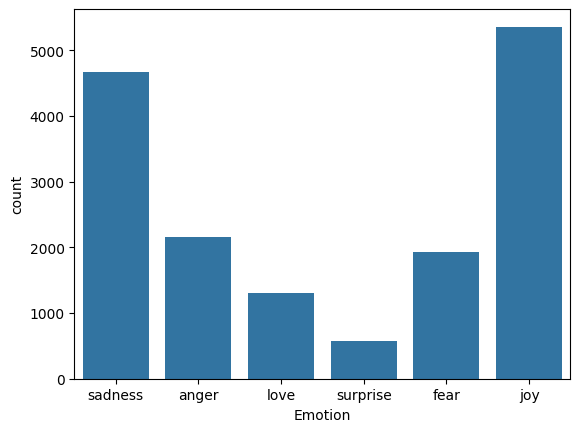

In [24]:
sns.countplot(x=train_data['Emotion'])
plt.show()

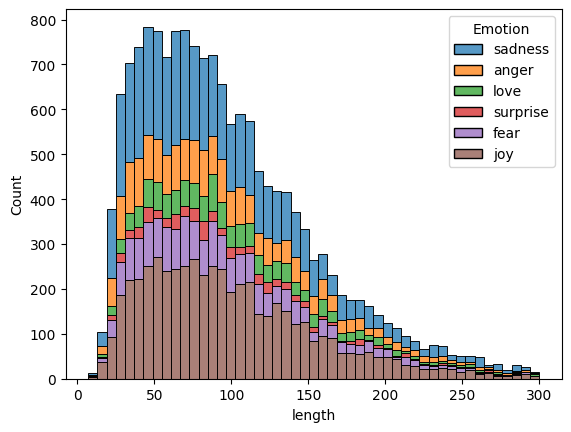

In [29]:
df2 = train_data.copy()
length_values = df2['length'].values
length_values
sns.histplot(data=df2,x = 'length', hue = 'Emotion',multiple = 'stack')
plt.show()

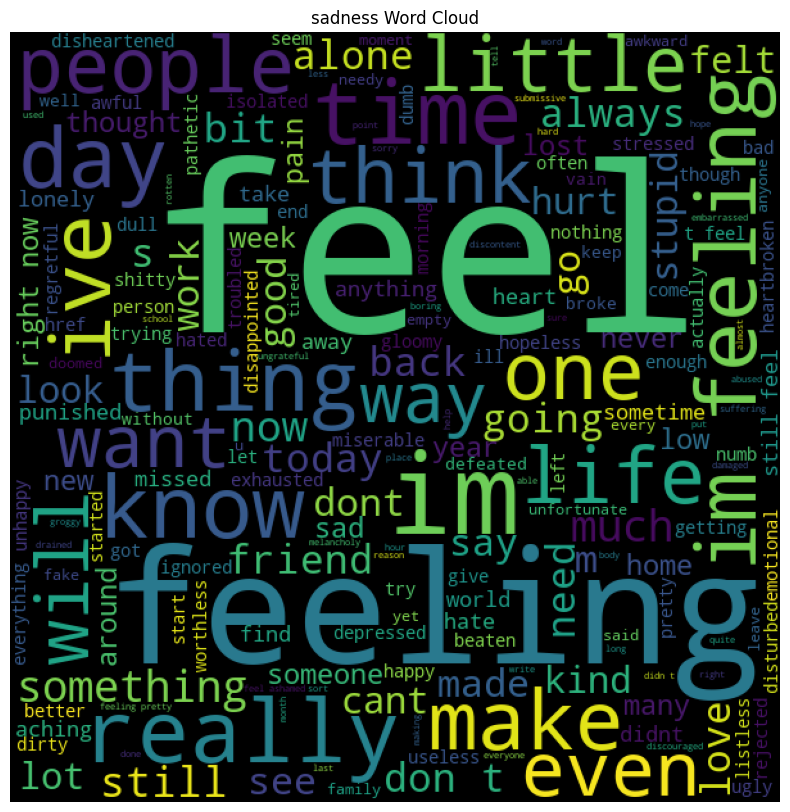

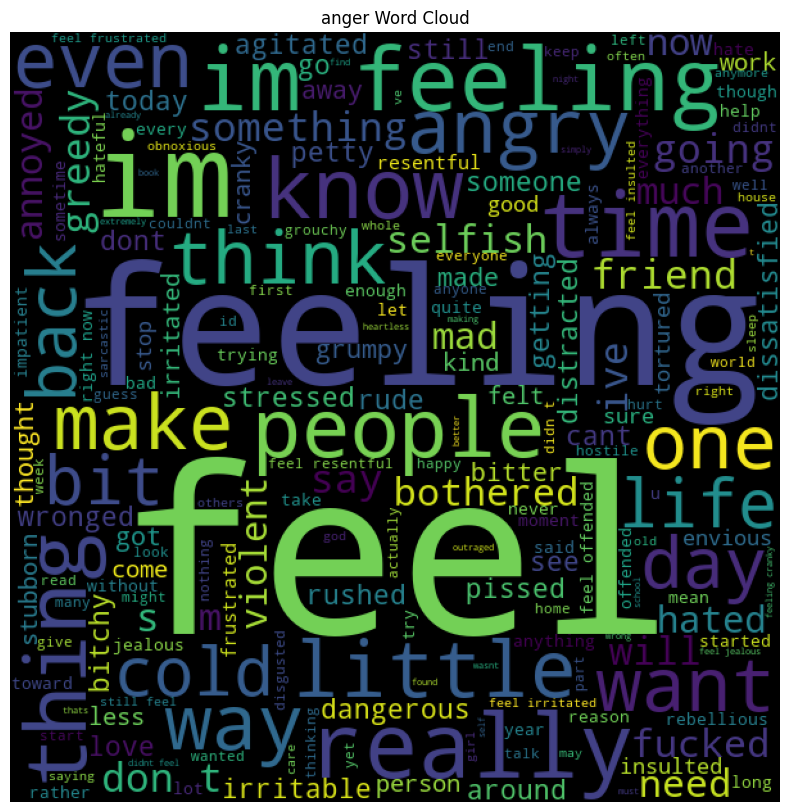

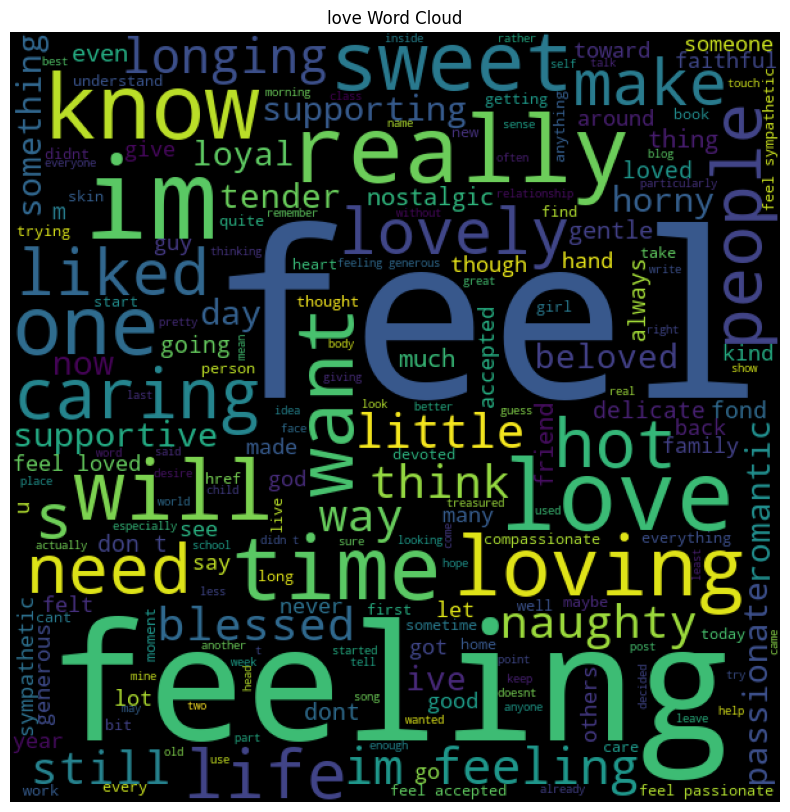

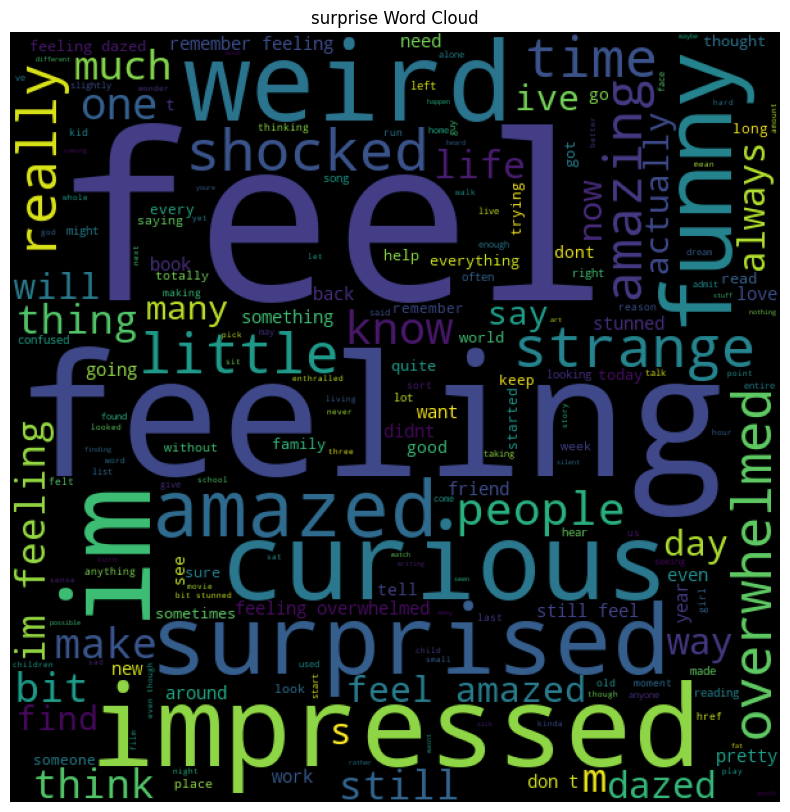

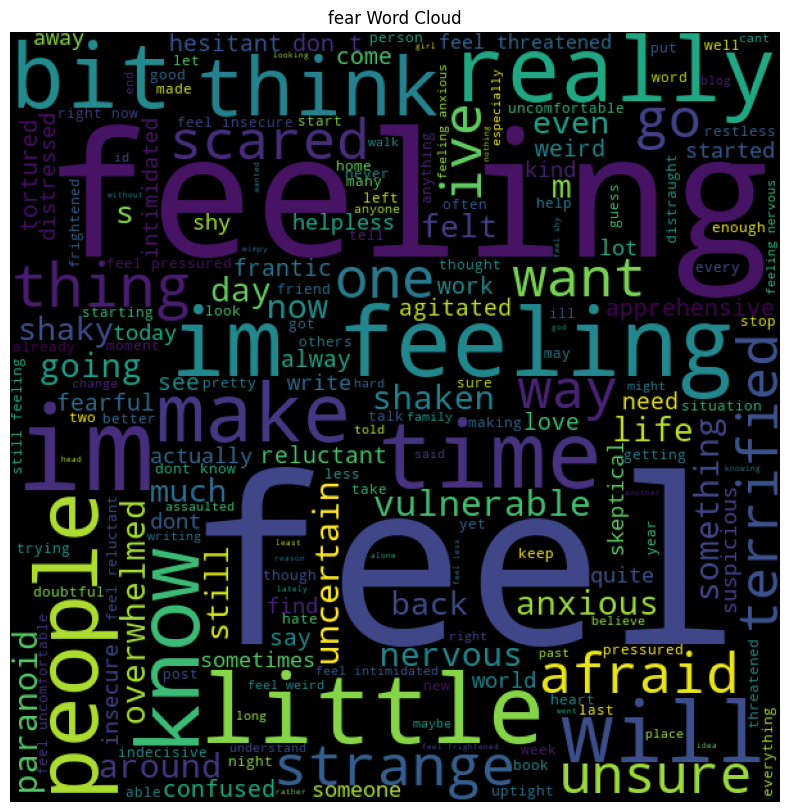

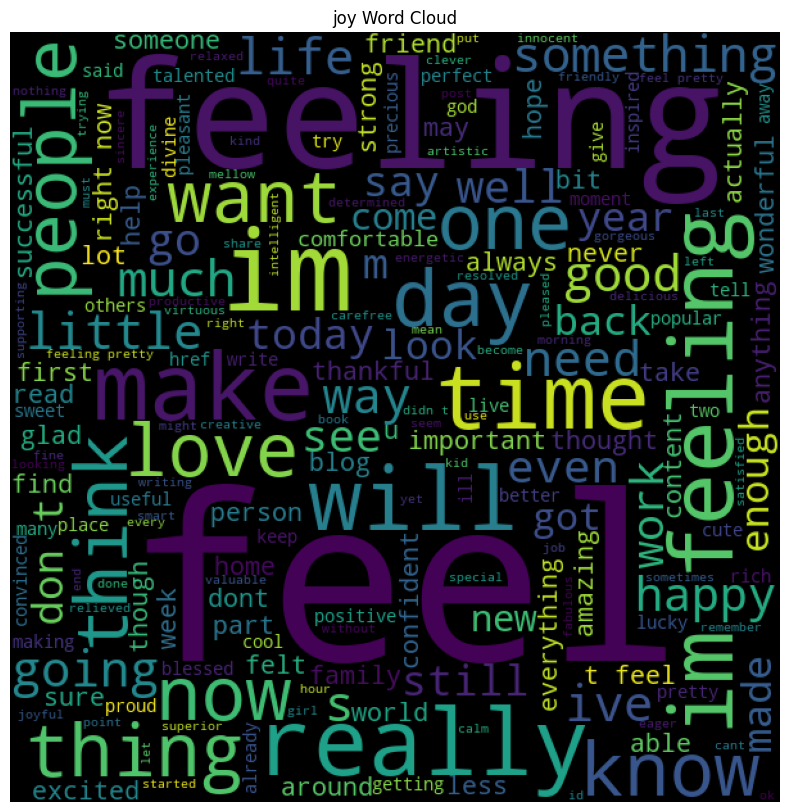

In [34]:
def words_cloud(wordcloud,emotion):
    plt.figure(figsize = (10,10))
    plt.title(emotion + " Word Cloud")
    plt.imshow(wordcloud)
    plt.axis("off")
       

emotions_list = train_data['Emotion'].unique()
for emotion in emotions_list:
    text = " ".join([sentence for sentence in train_data.loc[train_data['Emotion']==emotion,'Comment']])
    wordcloud = WordCloud(width=600,height=600).generate(text)
    words_cloud(wordcloud,emotion)

##Data Preprocessing
##Encode Emotions

In [35]:
lb = LabelEncoder()
train_data['Emotion_encoded'] = lb.fit_transform(train_data['Emotion'])

Apply Machine Learning

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,classification_report

In [39]:
df = train_data.copy()

In [40]:
df

,Comment,Emotion,length,Emotion_encoded
0,i didnt feel humiliated,sadness,23,4
1,i can go from feeling so hopeless to so damned...,sadness,108,4
2,im grabbing a minute to post i feel greedy wrong,anger,48,0
3,i am ever feeling nostalgic about the fireplac...,love,92,3
4,i am feeling grouchy,anger,20,0
...,...,...,...,...
15995,i just had a very brief time in the beanbag an...,sadness,101,4
15996,i am now turning and i feel pathetic that i am...,sadness,102,4
15997,i feel strong and good overall,joy,30,2
15998,i feel like this was such a rude comment and i...,anger,59,0


In [50]:
from nltk.corpus import stopwords
nltk.download('stopwords')
english_stopwords = stopwords.words('english')
stopword = len(english_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Len\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [57]:
import re
def clean_text(text):
    stemmer = PorterStemmer()
    text = re.sub("[^a-zA-Z]"," ",text)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in english_stopwords]
    return " ".join(text)
clean_text("I am 23323 % loving hating,hated,loved")

'love hate hate love'

In [58]:
df['cleaned_comment'] = df['Comment'].apply(clean_text)

In [59]:
df.head()

,Comment,Emotion,length,Emotion_encoded,cleaned_comment
0,i didnt feel humiliated,sadness,23,4,didnt feel humili
1,i can go from feeling so hopeless to so damned...,sadness,108,4,go feel hopeless damn hope around someon care ...
2,im grabbing a minute to post i feel greedy wrong,anger,48,0,im grab minut post feel greedi wrong
3,i am ever feeling nostalgic about the fireplac...,love,92,3,ever feel nostalg fireplac know still properti
4,i am feeling grouchy,anger,20,0,feel grouchi


In [61]:
X_train,X_test,y_train,y_test = train_test_split(df['cleaned_comment'],df['Emotion_encoded'],test_size=0.2,random_state=42)

In [64]:
X_train.head()

676      refer cours though cant help feel somehow iron...
14180           would feel awkward someon tell feel toward
7077     feel like probabl would like book littl bit si...
13004    ive slow take time listen child moment feel li...
10264                         feel vital rlsh gimmick need
Name: cleaned_comment, dtype: object

In [66]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [68]:
classifiers={
    "Multinomial Naive Bayes" : MultinomialNB(),
    "Logistic Regression" : LogisticRegression(),
    "Random Forest" : RandomForestClassifier(),
    "Support Vector Classifier" :SVC()
}

for name,clf in classifiers.items():
    print(f"============={name}==============")
    clf.fit(X_train_tfidf,y_train)
    y_pred_tfidf = clf.predict(X_test_tfidf)

    print(f"\nAccuracy using TF-IDF: {accuracy_score(y_test,y_pred_tfidf)}")
    print("Classification Report : ")
    print(classification_report(y_test,y_pred_tfidf))

=============Multinomial Naive Bayes==============

Accuracy using TF-IDF: 0.6590625
Classification Report : 
              precision    recall  f1-score   support

           0       0.95      0.32      0.48       439
           1       0.88      0.23      0.37       375
           2       0.58      0.98      0.73      1027
           3       1.00      0.03      0.05       303
           4       0.72      0.91      0.80       950
           5       1.00      0.02      0.04       106

    accuracy                           0.66      3200
   macro avg       0.85      0.42      0.41      3200
weighted avg       0.76      0.66      0.59      3200

=============Logistic Regression==============

Accuracy using TF-IDF: 0.825
Classification Report : 
              precision    recall  f1-score   support

           0       0.88      0.78      0.83       439
           1       0.85      0.72      0.78       375
           2       0.76      0.94      0.84      1027
           3       0.84     

In [70]:
lg = LogisticRegression()
lg.fit(X_train_tfidf,y_train)
y_pred_lg = lg.predict(X_test_tfidf)

In [72]:
def prediction(input_text):
    cleaned_text = clean_text(input_text)
    input_vectorized = tfidf_vectorizer.transform([cleaned_text])
    predicted_label = lg.predict(input_vectorized)[0]
    predicted_emotion = lb.inverse_transform([predicted_label])[0]
    label = np.max(lg.predict(input_vectorized)[0])
    return predicted_emotion,label

#Example usage
sentences = ["i didnt feel humiliated",
             "i feel strong and good overall",
             "im grabbing a minute to post i feel greedy wrong",
             "He was speechless when he found out he was accepted to this new job",
             "This is outrageous, how can you talk like that?",
             "I feel like im all in this world",
             "He is really caring and sweet",
             "You made me very crazy",
             "i am ever feeling nostalgic about the fireplace i will know that it is still on the proper thing",
             "i am feeling gouchy",
             "He hates you"]
             

for sent in sentences:
    print(sent)
    predict_emotion,label = prediction(sent)
    print("predicted Emotion :",predict_emotion)
    print("Predicted Label :",label)
    print("===================================================")

i didnt feel humiliated
predicted Emotion : sadness
Predicted Label : 4
i feel strong and good overall
predicted Emotion : joy
Predicted Label : 2
im grabbing a minute to post i feel greedy wrong
predicted Emotion : anger
Predicted Label : 0
He was speechless when he found out he was accepted to this new job
predicted Emotion : joy
Predicted Label : 2
This is outrageous, how can you talk like that?
predicted Emotion : anger
Predicted Label : 0
I feel like im all in this world
predicted Emotion : joy
Predicted Label : 2
He is really caring and sweet
predicted Emotion : love
Predicted Label : 3
You made me very crazy
predicted Emotion : sadness
Predicted Label : 4
i am ever feeling nostalgic about the fireplace i will know that it is still on the proper thing
predicted Emotion : love
Predicted Label : 3
i am feeling gouchy
predicted Emotion : joy
Predicted Label : 2
He hates you
predicted Emotion : anger
Predicted Label : 0


In [74]:
import pickle
pickle.dump(lg,open("logistic_regression.pkl","wb"))
pickle.dump(lb,open("label_encoder.pkl",'wb'))
pickle.dump(tfidf_vectorizer,open("tfidf_vectorizer.pkl",'wb'))

In [76]:
import sklearn

1.5.0


In [78]:
train_data = train_data.drop(columns=['Emotion_encoded'])

In [79]:
train_data.head()

,Comment,Emotion,length
0,i didnt feel humiliated,sadness,23
1,i can go from feeling so hopeless to so damned...,sadness,108
2,im grabbing a minute to post i feel greedy wrong,anger,48
3,i am ever feeling nostalgic about the fireplac...,love,92
4,i am feeling grouchy,anger,20


In [96]:
def clean_text(df,column,vocab_size,max_len):
    stemmer = PorterStemmer()

    corpus = []
    for text in df[column]:
        text = re.sub("[^a-zA-Z]",' ',text)
        text = text.lower()
        text = text.split()
        text = [stemmer.stem(w) for w in text if w not in english_stopwords]
        text = " ".join(text)
        corpus.append(text)
    one_hot_word = [one_hot(input_text=word,n=vocab_size)for word in corpus]
    pad = pad_sequences(sequences=one_hot_word,maxlen=max_len,padding='pre')
    return pad

x_train = clean_text(train_data,'Comment',vocab_size = 11000,max_len=300)

In [99]:
train_data['Emotion']

0        4
1        4
2        0
3        3
4        0
        ..
15995    4
15996    4
15997    2
15998    0
15999    4
Name: Emotion, Length: 15999, dtype: int32

In [100]:
train_data

,Comment,Emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108
2,im grabbing a minute to post i feel greedy wrong,0,48
3,i am ever feeling nostalgic about the fireplac...,3,92
4,i am feeling grouchy,0,20
...,...,...,...
15995,i just had a very brief time in the beanbag an...,4,101
15996,i am now turning and i feel pathetic that i am...,4,102
15997,i feel strong and good overall,2,30
15998,i feel like this was such a rude comment and i...,0,59


In [101]:
lb = LabelEncoder()
train_data['Emotion'] = lb.fit_transform(train_data['Emotion'])

In [102]:
y_train = to_categorical(train_data['Emotion'])

Model Building and Training

In [103]:
model = Sequential()
model.add(Embedding(input_dim=11000, output_dim=150, input_length=300))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(64,activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(6,activation='softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(x_train,y_train,epochs = 10,batch_size = 64,verbose=1)

C:\Users\Len\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 77s 298ms/step - accuracy: 0.3566 - loss: 1.5555
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 79s 315ms/step - accuracy: 0.8078 - loss: 0.5609
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 79s 316ms/step - accuracy: 0.9067 - loss: 0.2840
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 85s 340ms/step - accuracy: 0.9350 - loss: 0.2011
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 92s 369ms/step - accuracy: 0.9515 - loss: 0.1445


Predictive system

In [112]:
def pred(text):
    stemmer = PorterStemmer()
    corpus = []
    text = re.sub("[^a-zA-Z]",' ',text)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(w) for w in text if w not in english_stopwords]
    text = " ".join(text)
    corpus.append(text)
    one_hot_word = [one_hot(input_text=word,n=11000)for word in corpus]
    pad = pad_sequences(sequences=one_hot_word,maxlen=300,padding='pre')
    return pad

sentences = ["i didnt feel humiliated",
             "i feel strong and good overall",
             "im grabbing a minute to post i feel greedy wrong",
             "He was speechless when he found out he was accepted to this new job",
             "This is outrageous, how can you talk like that?",
             "I feel like im all in this world",
             "He is really caring and sweet",
             "You made me very crazy",
             "i am ever feeling nostalgic about the fireplace i will know that it is still on the proper thing",
             "i am feeling gouchy",
             "He hates you"
            ]
for sent in sentences:
    clean_sentence_with_padding = pred(sent)
    emotion_index = np.argmax(model.predict(clean_sentence_with_padding), axis=-1)[0]
    emotion = lb.inverse_transform([emotion_index])[0]
    label = np.max(model.predict(clean_sentence_with_padding))
    print(emotion_index)
    print(label)
    print("============================================================")
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
4
0.99638164


C:\Users\Len\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2
0.99854976


C:\Users\Len\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
0
0.99133694


C:\Users\Len\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2
0.29008213
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


C:\Users\Len\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Len\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
0
0.8103237
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2
0.7479633
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


C:\Users\Len\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Len\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
3
0.8940612
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
4
0.5276471
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


C:\Users\Len\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Len\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
3
0.96338063
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2
0.6096934
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


C:\Users\Len\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Len\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
0
0.8669056


In [113]:
model.save('model.h5')